## Assignment Part 2


### 2A: Extracting vessels from raw fundus images

1. Load the color image. Using subplots, display each color channel separately.

Text(0.5, 1.0, 'Blue channel')

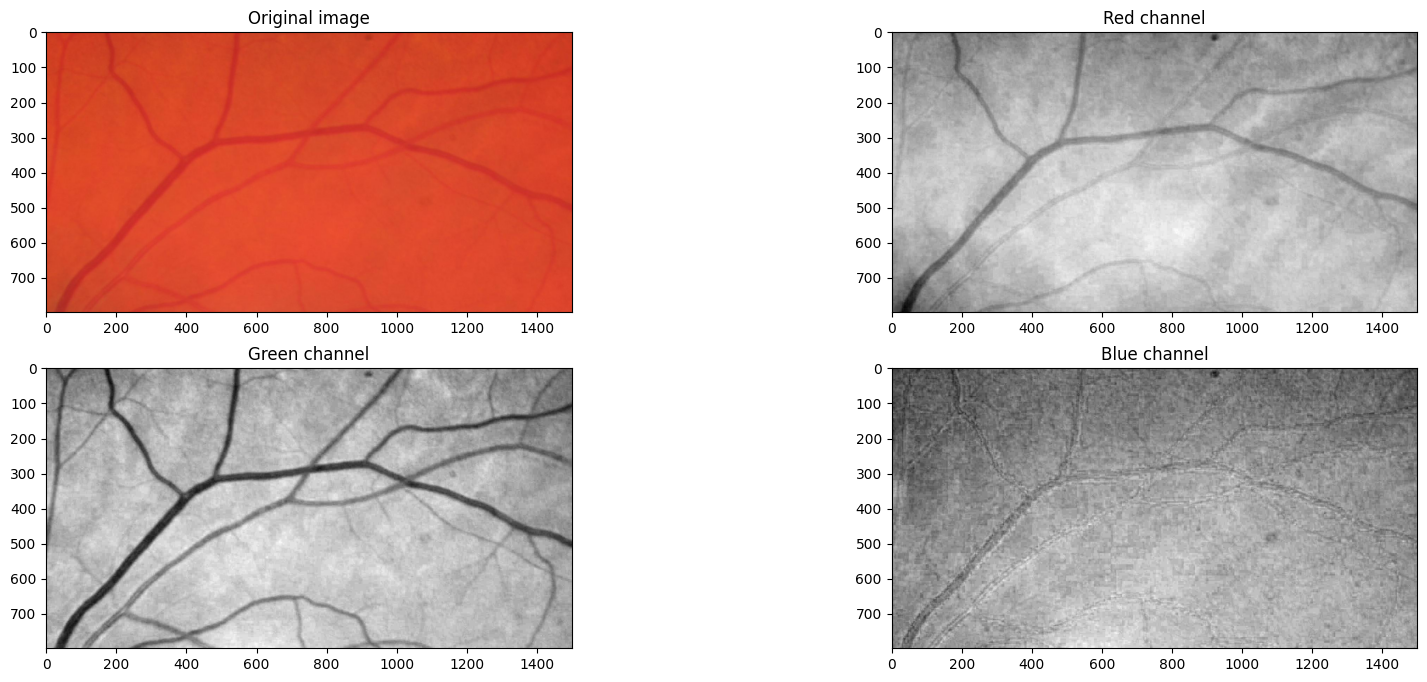

In [2]:
from skimage import io 
import matplotlib.pyplot as plt

# Loading the image
im = io.imread('./2072964/2072964_vesselimage.jpg')

# Displaying each channel
plt.figure(figsize = (20,8))
plt.subplot(221)
plt.imshow(im)
plt.title('Original image')
plt.subplot(222)
plt.imshow(im[:,:,0], cmap = 'gray')
plt.title('Red channel')
plt.subplot(223)
plt.imshow(im[:,:,1], cmap = 'gray')
plt.title('Green channel')
plt.subplot(224)
plt.imshow(im[:,:,2], cmap = 'gray')
plt.title('Blue channel')



2. Convert the color image to HSV and display the hue, saturation and value channels.

Text(0.5, 1.0, 'Value')

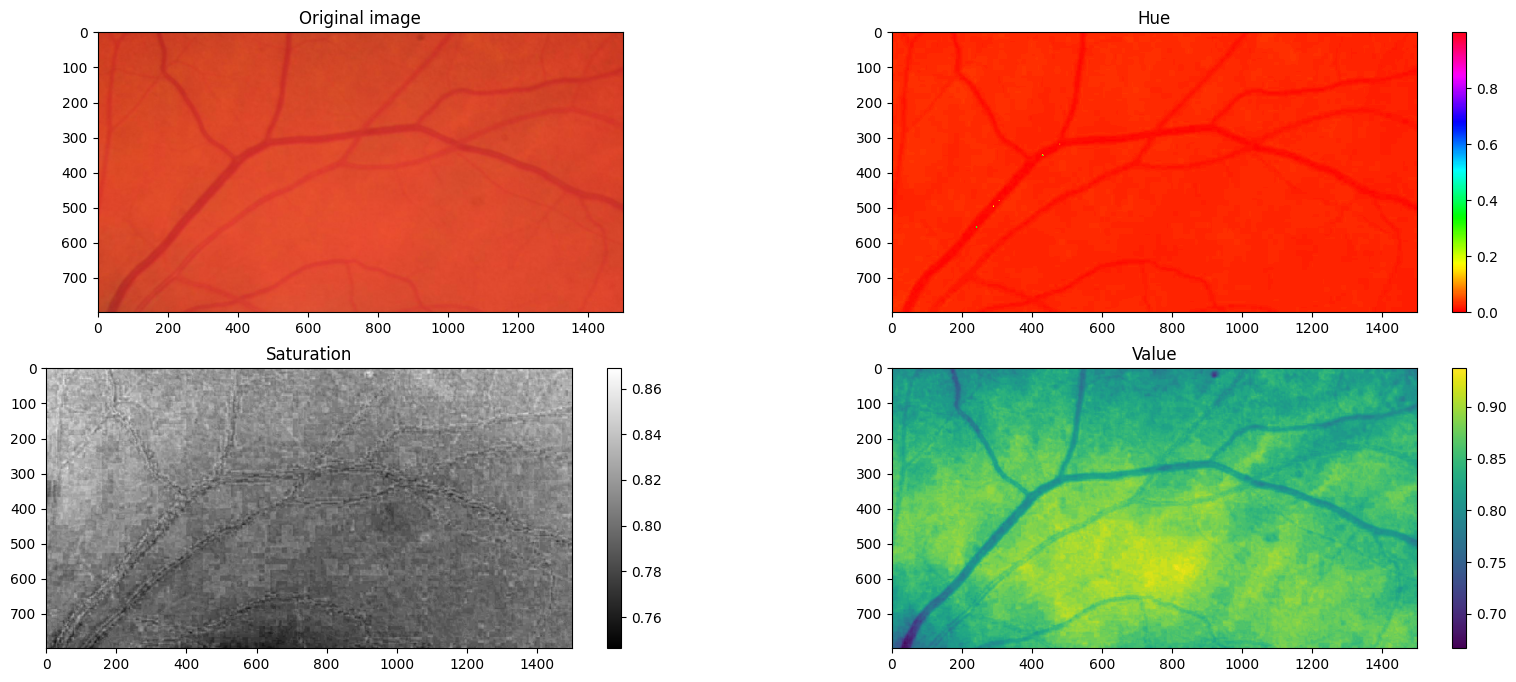

In [3]:
from skimage import io, color

# Converting the image from rgb into hsv
imhsv = color.rgb2hsv(im)

# Displaying the hsv channels
plt.figure(figsize = (20,8))
plt.subplot(221)
plt.imshow(im)
plt.title('Original image')
plt.subplot(222)
plt.imshow(imhsv[:,:,0], cmap = 'hsv')
plt.colorbar()
plt.title('Hue')
plt.subplot(223)
plt.imshow(imhsv[:,:,1], cmap = 'gray')
plt.colorbar()
plt.title('Saturation')
plt.subplot(224)
plt.imshow(imhsv[:,:,2], cmap = 'viridis')
plt.colorbar()
plt.title('Value')


3. Segment the vessels to obtain a binary image where pixels representing the vessels are set to 1. You can apply morphological operations on these images.

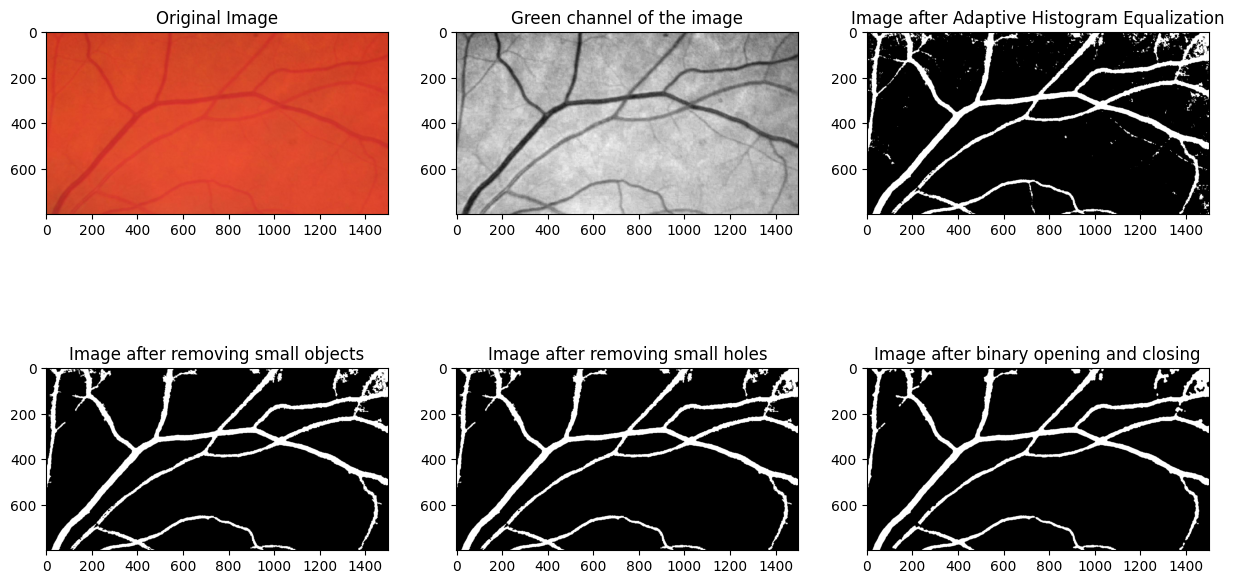

In [4]:
from scipy.ndimage import binary_fill_holes
from skimage.morphology import dilation, erosion, opening, closing, white_tophat
from skimage.morphology import disk, diamond
from skimage.filters import try_all_threshold
from skimage.util import random_noise, img_as_float
from skimage import io, exposure, filters, morphology
import matplotlib.pyplot as plt
import numpy as np

# Extracting the green channel as it is displays the vessels the best
im2 = im[:,:,1]

# Performing adaptive histogram equalization to improve the contrast
img_adapteq = exposure.equalize_adapthist(im2, clip_limit=0.03) 

im2 = img_as_float(im2)

# fig, ax = try_all_threshold(img_adapteq, figsize=(20, 8), verbose=False)
# plt.show()

# Inverting the colors in the image so that the vessels become white and the background black
inverted = 1 - img_adapteq

# Displaying the results
plt.figure(figsize=(15, 8))
plt.subplot(231)
plt.title('Original Image')
plt.imshow(im, cmap='gray')

plt.subplot(232)
plt.title('Green channel of the image')
plt.imshow(im2, cmap='gray')

# Apply Yen thresholding
threshold_value = filters.threshold_yen(inverted)
vessel_mask = inverted > threshold_value

plt.subplot(233)
plt.title('Image after Adaptive Histogram Equalization')
plt.imshow(vessel_mask, cmap='gray')

# Removing small objects 
cleaned_mask = morphology.remove_small_objects(vessel_mask, min_size=400)

plt.subplot(234)
plt.title('Image after removing small objects')
plt.imshow(cleaned_mask, cmap='gray')

# Removing small holes inside the vessels
cleaned_mask = morphology.remove_small_holes(cleaned_mask, area_threshold=100)

plt.subplot(235)
plt.title('Image after removing small holes')
plt.imshow(cleaned_mask, cmap='gray')

# Applying a morphological opening to smooth boundaries
cleaned_mask = morphology.binary_opening(cleaned_mask, morphology.disk(3))

# Applying a morphological opening to smooth boundaries
cleaned_mask = morphology.binary_closing(cleaned_mask, morphology.disk(3))

plt.subplot(236)
plt.title('Image after binary opening and closing')
plt.imshow(cleaned_mask, cmap='gray')


4. Overlay your segmentation solutions with the binary mask found in the image

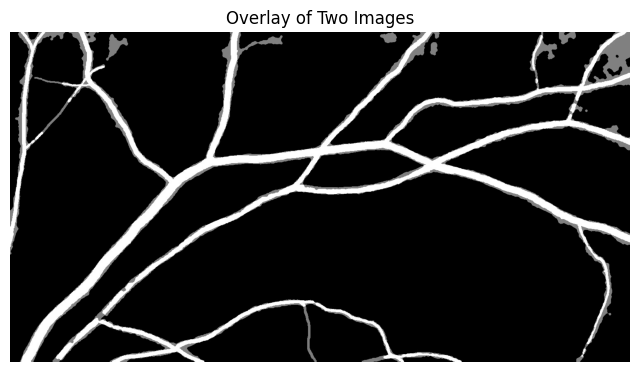

In [5]:
mask_im = io.imread('./2072964/2072964_vesselmask.jpg')

# Creating the overlay
plt.figure(figsize=(8, 8))
plt.imshow(cleaned_mask, cmap='gray')           
plt.imshow(mask_im, cmap='gray', alpha=0.5) 

plt.axis('off')
plt.title('Overlay of Two Images')
plt.show()


5. Compute the Dice or Jaccard score between your solution and the binary mask.

In [10]:
from sklearn.metrics import jaccard_score

# Making sure the images are binary
mask_im2 = (mask_im > 0).astype(int)                
cleaned_mask2 = (cleaned_mask > 0).astype(int)     

# Flattening the arrays
mask_im_flat = mask_im2.flatten()
cleaned_mask_flat = cleaned_mask2.flatten()

# Performing the Jaccard measurement
jaccard = jaccard_score(mask_im2.flatten(), cleaned_mask2.flatten())
print(jaccard)

0.627159436137054


## 2B: Processing a binary image of segmented vessels

1. Remove smaller vessels (less than 8 pixels wide) with a morphological opening. Apply morphological thinning to obtain a 1-pixel thin centerline of the vascular network.

Text(0.5, 1.0, 'Image after performing thinning')

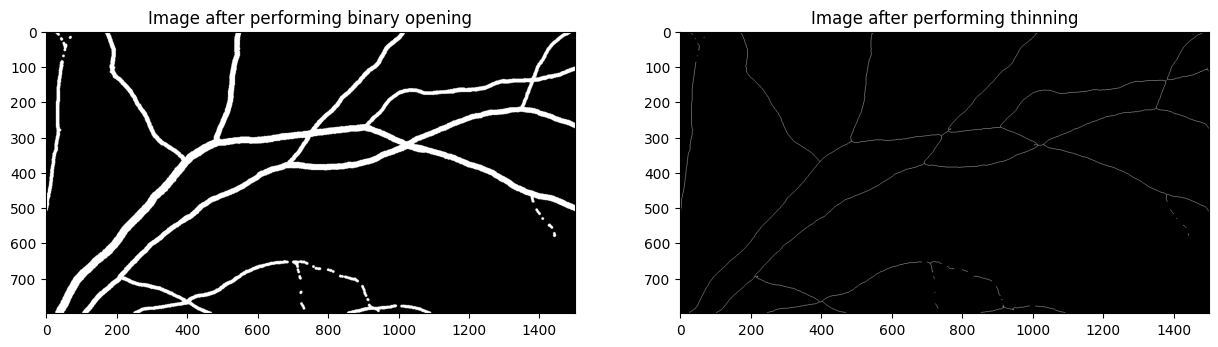

In [7]:
from skimage.morphology import thin
from skimage.morphology import square, rectangle, diamond, disk
from skimage.morphology import  binary_opening, binary_closing

# Defining a structuring element
se = disk(4)

# Performing a binary opening
im_mask = binary_opening(mask_im, se)

# Displaying the results
plt.figure(figsize = (15, 8))
plt.subplot(121)
plt.imshow(im_mask, cmap = 'gray')
plt.title('Image after performing binary opening')
plt.subplot(122)
thinned = thin(im_mask, max_num_iter = 50)
plt.imshow(thinned, cmap = 'gray')
plt.title('Image after performing thinning')

2. Find the overall length of the vascular network (in pixels) in the image after thinning. This is the total number of pixels which are set to 1 or True, after morphological thinning.

In [8]:
# Calculating the number of pixels by summing them
length = np.sum(thinned)
print(length)

6598


4. Compute the orientation of the vascular network in the image after thinning. Display the orientation distribution of the vascular network in a polar (rose) plot.

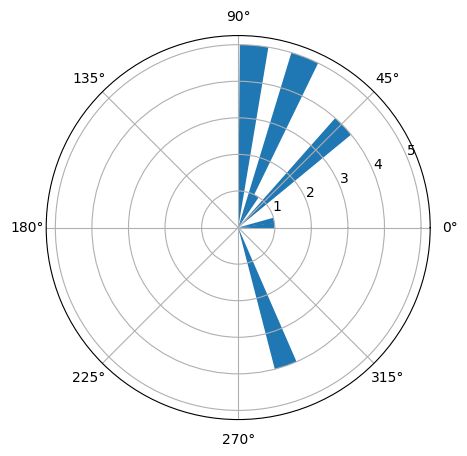

In [9]:
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks

# Performing canny edge detection 
im_edges  = feature.canny(thinned, sigma=1,low_threshold=0, high_threshold=1)
im_edges = im_edges[2:thinned.shape[0]-2,2:thinned.shape[1]-2]

# Using hough transforms to find lines on the edge detection results
[H, theta, rho] = hough_line(im_edges)
hspace, angles, dists = hough_line_peaks(H, theta, rho,num_peaks=50)

# Displaying the number of lines at each range of angles in a polar (rose) plot 
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
N = 20
radii = np.histogram(angles,bins=N)
atheta = np.linspace(min(angles), max(angles), N)

width = np.pi/N 
bars = plt.bar(atheta, radii[0], width=width, bottom=0.0)

ChatGPT was utilized at times for writing certain code snippets.